In [2]:
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lazypredict.Supervised import LazyClassifier
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from collections import Counter
from scipy.stats import reciprocal
import skopt
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_evaluations
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def set_color(x, colormap_name = 'tab20'):
    # This function returns a dictionary of colors based on the input numpy x of metadata values
    # The default colormap is tab10 (tableau 10), but any named colormap can be used
    categories = np.unique(x)
    if colormap_name == 'health':
        clr = {'D': 'orange',
               'H': 'green',
               'LLRZ': 'gold',
               'MX': 'olive',
               'NA': 'gray',
               'R': 'red',
               'S': 'goldenrod',
               }
        
    else:
        if colormap_name == 'custom':
            color_list = ['r','g','b','c','m','y','maroon','orange',
                'darkgreen','lime','navy','teal',
                'indigo','crimson','pink','slategrey',
                'darkgoldenrod','purple']
            clr = {}
            for i,category in enumerate(categories):
                clr[category] = color_list[i]
        else:
            clr = {}
            cmap = matplotlib.cm.get_cmap(colormap_name)
            for i,category in enumerate(categories):
                clr[category] = cmap(i/len(categories))
    return clr 

# Load the UPWINS spectral library and metadata csv

In [3]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('data/spectra.npy')
wl = np.load('data/wl.npy')
genus = np.load('data/genus.npy')
species = np.load('data/species.npy')
principle_part = np.load('data/principle_part.npy')
health = np.load('data/health.npy')
growth_stage = np.load('data/growth_stage.npy')
DateTimeId = np.load('data/DateTimeId.npy')
month = np.load('data/month.npy')
name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)
name_genus_species = np.load('data/name_genus_species.npy')# the genus and species if known - otherwise NA
name_full_category = np.load('data/name_full_category.npy')# all the metadata available in one string
plant_type = np.load('data/plant_type.npy')# the type of plant (tree, shrub, grass, etc.) - otherwise NA


# Set colormaps
clr_custom = set_color(name, 'custom')
clr_n = set_color(name)
clr_h = set_color(health, 'health')


nSpec = spectra.shape[0]
nBands = spectra.shape[1]
print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')

Number of Spectra: 902
Number of Bands: 2151


# Take a look at the data

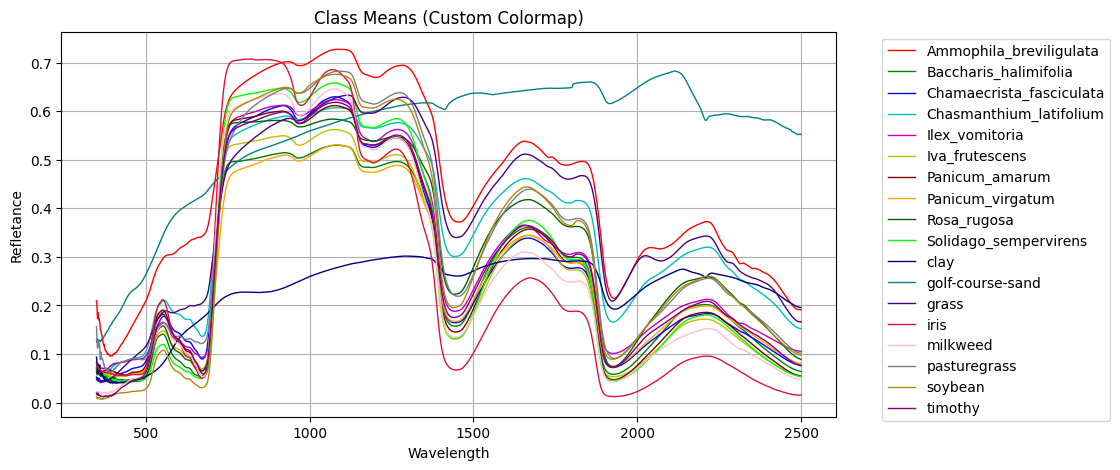

In [4]:
# plot the mean of each class
plt.figure(figsize=(10,5))
plt.grid(True)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    mean_spectrum = np.mean(spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, lw=1, c=clr_custom[n])
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means (Custom Colormap)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

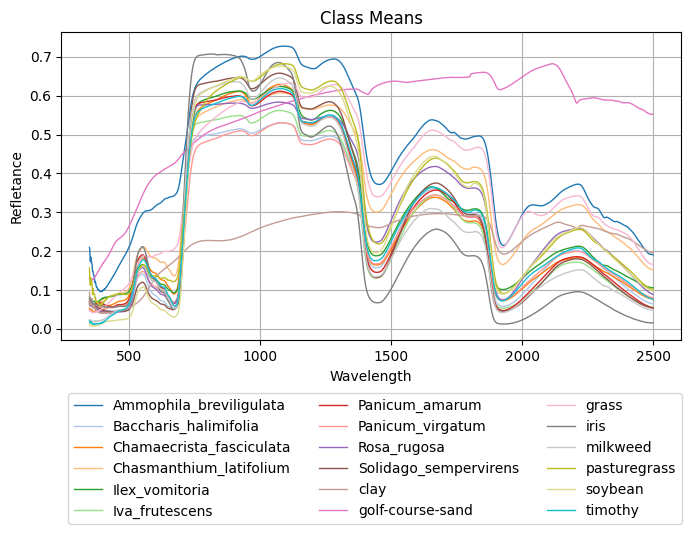

In [20]:
# plot the mean of each class
plt.figure(figsize=(8,4))
plt.grid(True)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    mean_spectrum = np.mean(spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, lw=1, c=clr_n[n])
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means')
plt.legend(bbox_to_anchor=(0.0, -0.15), ncols=3, loc='upper left');
plt.savefig('output/meanSpectra.png')

# Prepare the data for training and testing

In [6]:
# Assemble X and Y for training
X = spectra
Yn = name
Yg = genus
Ys = species
Ypp = principle_part
Yh = health
Ygs = growth_stage
Yd = DateTimeId
Ym = month
Yngs = name_genus_species
Ynfc = name_full_category
Ypt = plant_type
print(X.shape,Yn.shape)
print(f'Number of genus: {len(np.unique(Yg))}: {np.unique(Yg)}\n')
print(f'Number of species: {len(np.unique(Ys))}: {np.unique(Ys)}\n')
print(f'Number of principle_parts: {len(np.unique(Ypp))}: {np.unique(Ypp)}\n')
print(f'Number of health categories: {len(np.unique(Yh))}: {np.unique(Yh)}\n')
print(f'Number of growth stage categories: {len(np.unique(Ygs))}: {np.unique(Ygs)}\n')
print(f'Number of Date-Time_Id values: {len(np.unique(Yd))}\n')
print(f'Number of months: {len(np.unique(Ym))}: {np.unique(Ym)}\n')
print(f'Number of names: {len(np.unique(Yn))}: {np.unique(Yn)}\n')
print(f'Number of name_genus_species categories: {len(np.unique(Yngs))}: {np.unique(Yngs)}\n')
print(f'Number of name_full_categories: {len(np.unique(Ynfc))}\n')
print(f'Number of plant types: {len(np.unique(Ypt))}: {np.unique(Ypt)}\n')

(902, 2151) (902,)
Number of genus: 10: ['Ammophila' 'Baccharis' 'Chamaecrista' 'Chasmanthium' 'Ilex' 'Iva' 'NA'
 'Panicum' 'Rosa' 'Solidago']

Number of species: 11: ['NA' 'amarum' 'breviligulata' 'fasciculata' 'frutescens' 'halimifolia'
 'latifolium' 'rugosa' 'sempervirens' 'virgatum' 'vomitoria']

Number of principle_parts: 10: ['B' 'CS' 'FL' 'L' 'MX' 'NA' 'RS' 'S' 'SA' 'St']

Number of health categories: 7: ['D' 'H' 'LLRZ' 'MX' 'NA' 'R' 'S']

Number of growth stage categories: 8: [' M' '1G' 'D' 'E' 'FL' 'M' 'NA' 'RE']

Number of Date-Time_Id values: 902

Number of months: 8: ['01' '02' '03' '04' '07' '10' '11' '12']

Number of names: 18: ['Ammophila_breviligulata' 'Baccharis_halimifolia'
 'Chamaecrista_fasciculata' 'Chasmanthium_latifolium' 'Ilex_vomitoria'
 'Iva_frutescens' 'Panicum_amarum' 'Panicum_virgatum' 'Rosa_rugosa'
 'Solidago_sempervirens' 'clay' 'golf-course-sand' 'grass' 'iris'
 'milkweed' 'pasturegrass' 'soybean' 'timothy']

Number of name_genus_species categories: 11: 

# Classification Algorithm Comparison with LazyClassifier

Classification based on the class name (genus-species, or similar)

In [7]:
# Select the variable for prediction
Y_type = Yn

# Create an integer-values category label
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0][0]
    
# Create a test-train split
X_train_80pct, X_test, Y_train_80pct, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_80pct, Y_train_80pct, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print('The initial \'80pct\' split size: ', end='')
print(X_train_80pct.shape,Y_train_80pct.shape[0] / Y.shape[0])
print('The training split size: ', end='')
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print('The test split size: ', end='')
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print('The validation split size: ', end='')
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

The initial '80pct' split size: (721, 2151) 0.7993348115299335
The training split size: (540, 2151) 0.5986696230598669
The test split size: (181, 2151) 0.2006651884700665
The validation split size: (181, 2151) 0.2006651884700665


In [21]:
# Classification results using lazy classifier
rerun_LazyClassifier = False
if rerun_LazyClassifier:
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train_80pct, X_test, Y_train_80pct, Y_test)
    models.to_csv('output/LazyClassifier_results_genus_species.csv')
else:
    models = pd.read_csv('output/LazyClassifier_results_genus_species.csv')
models

,Model,Accuracy,Balanced Accuracy,F1 Score,Time Taken
0,LinearDiscriminantAnalysis,0.91,0.91,0.92,0.61
1,RidgeClassifierCV,0.87,0.86,0.87,0.23
2,ExtraTreesClassifier,0.87,0.85,0.87,0.63
3,BaggingClassifier,0.86,0.84,0.86,13.11
4,RandomForestClassifier,0.86,0.84,0.86,2.07
5,LGBMClassifier,0.85,0.84,0.86,50.84
6,XGBClassifier,0.85,0.83,0.85,63.16
7,ExtraTreeClassifier,0.80,0.81,0.81,0.08
8,CalibratedClassifierCV,0.82,0.80,0.82,96.91
9,RidgeClassifier,0.81,0.79,0.81,0.14


In [22]:
print(models)

                            Model  Accuracy  Balanced Accuracy  F1 Score  \
0      LinearDiscriminantAnalysis      0.91               0.91      0.92   
1               RidgeClassifierCV      0.87               0.86      0.87   
2            ExtraTreesClassifier      0.87               0.85      0.87   
3               BaggingClassifier      0.86               0.84      0.86   
4          RandomForestClassifier      0.86               0.84      0.86   
5                  LGBMClassifier      0.85               0.84      0.86   
6                   XGBClassifier      0.85               0.83      0.85   
7             ExtraTreeClassifier      0.80               0.81      0.81   
8          CalibratedClassifierCV      0.82               0.80      0.82   
9                 RidgeClassifier      0.81               0.79      0.81   
10                      LinearSVC      0.78               0.76      0.79   
11         DecisionTreeClassifier      0.78               0.75      0.78   
12          

Classification base on the full category label

In [9]:
# Select the variable for prediction
Y_type = Yngs

# Create an integer-values category label
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0][0]
    
# Create a test-train split
X_train_80pct, X_test, Y_train_80pct, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # 20% of the data in the test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train_80pct, Y_train_80pct, test_size=0.25, random_state=42) # 20% of the data in the validation set, 60% in the training set
print('The initial \'80pct\' split size: ', end='')
print(X_train_80pct.shape,Y_train_80pct.shape[0] / Y.shape[0])
print('The training split size: ', end='')
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print('The test split size: ', end='')
print(X_test.shape,Y_test.shape[0] / Y.shape[0])
print('The validation split size: ', end='')
print(X_val.shape,Y_val.shape[0] / Y.shape[0])

The initial '80pct' split size: (721, 2151) 0.7993348115299335
The training split size: (540, 2151) 0.5986696230598669
The test split size: (181, 2151) 0.2006651884700665
The validation split size: (181, 2151) 0.2006651884700665


In [10]:
# Classification results using lazy classifier
rerun_LazyClassifier = False
if rerun_LazyClassifier:
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models,predictions = clf.fit(X_train_80pct, X_test, Y_train_80pct, Y_test)
    models.to_csv('output/LazyClassifier_results_full_category.csv')
else:
    models = pd.read_csv('output/LazyClassifier_results_full_category.csv')
models

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,LinearDiscriminantAnalysis,0.93,0.94,NaN,0.93,0.46
1,ExtraTreesClassifier,0.88,0.87,NaN,0.88,0.49
2,RandomForestClassifier,0.88,0.86,NaN,0.88,1.91
3,LGBMClassifier,0.87,0.86,NaN,0.87,40.21
4,RidgeClassifierCV,0.85,0.85,NaN,0.85,0.21
5,BaggingClassifier,0.86,0.85,NaN,0.86,7.53
6,XGBClassifier,0.85,0.85,NaN,0.85,30.36
7,ExtraTreeClassifier,0.80,0.80,NaN,0.80,0.07
8,RidgeClassifier,0.78,0.77,NaN,0.78,0.11
9,CalibratedClassifierCV,0.78,0.76,NaN,0.78,61.07


# PCA Visualization

In [11]:
# All data
pca_all = PCA(n_components=10)
pca_all.fit(spectra)
pca_all_X = pca_all.transform(spectra)
# Healthy veg
pca_healthy = PCA(n_components=10)
idx_healthy = np.where(health=='H')[0]
pca_healthy.fit(spectra[idx_healthy])
pca_healthy_X = pca_healthy.transform(spectra[idx_healthy])
# Domrant veg
pca_dormant = PCA(n_components=10)
idx_dormant = np.where(health=='D')[0]
pca_dormant.fit(spectra[idx_dormant])
pca_dormant_X = pca_dormant.transform(spectra[idx_dormant])
# Once for each name
index = {}
pca = {}
pca_X = {}
for n in np.unique(name):
    index[n] = np.where(name==n)[0]
    pca[n] = PCA(n_components= min([10, len(index[n])]))
    pca[n].fit(spectra[index[n]])
    pca_X[n] = pca[n].transform(spectra[index[n]])

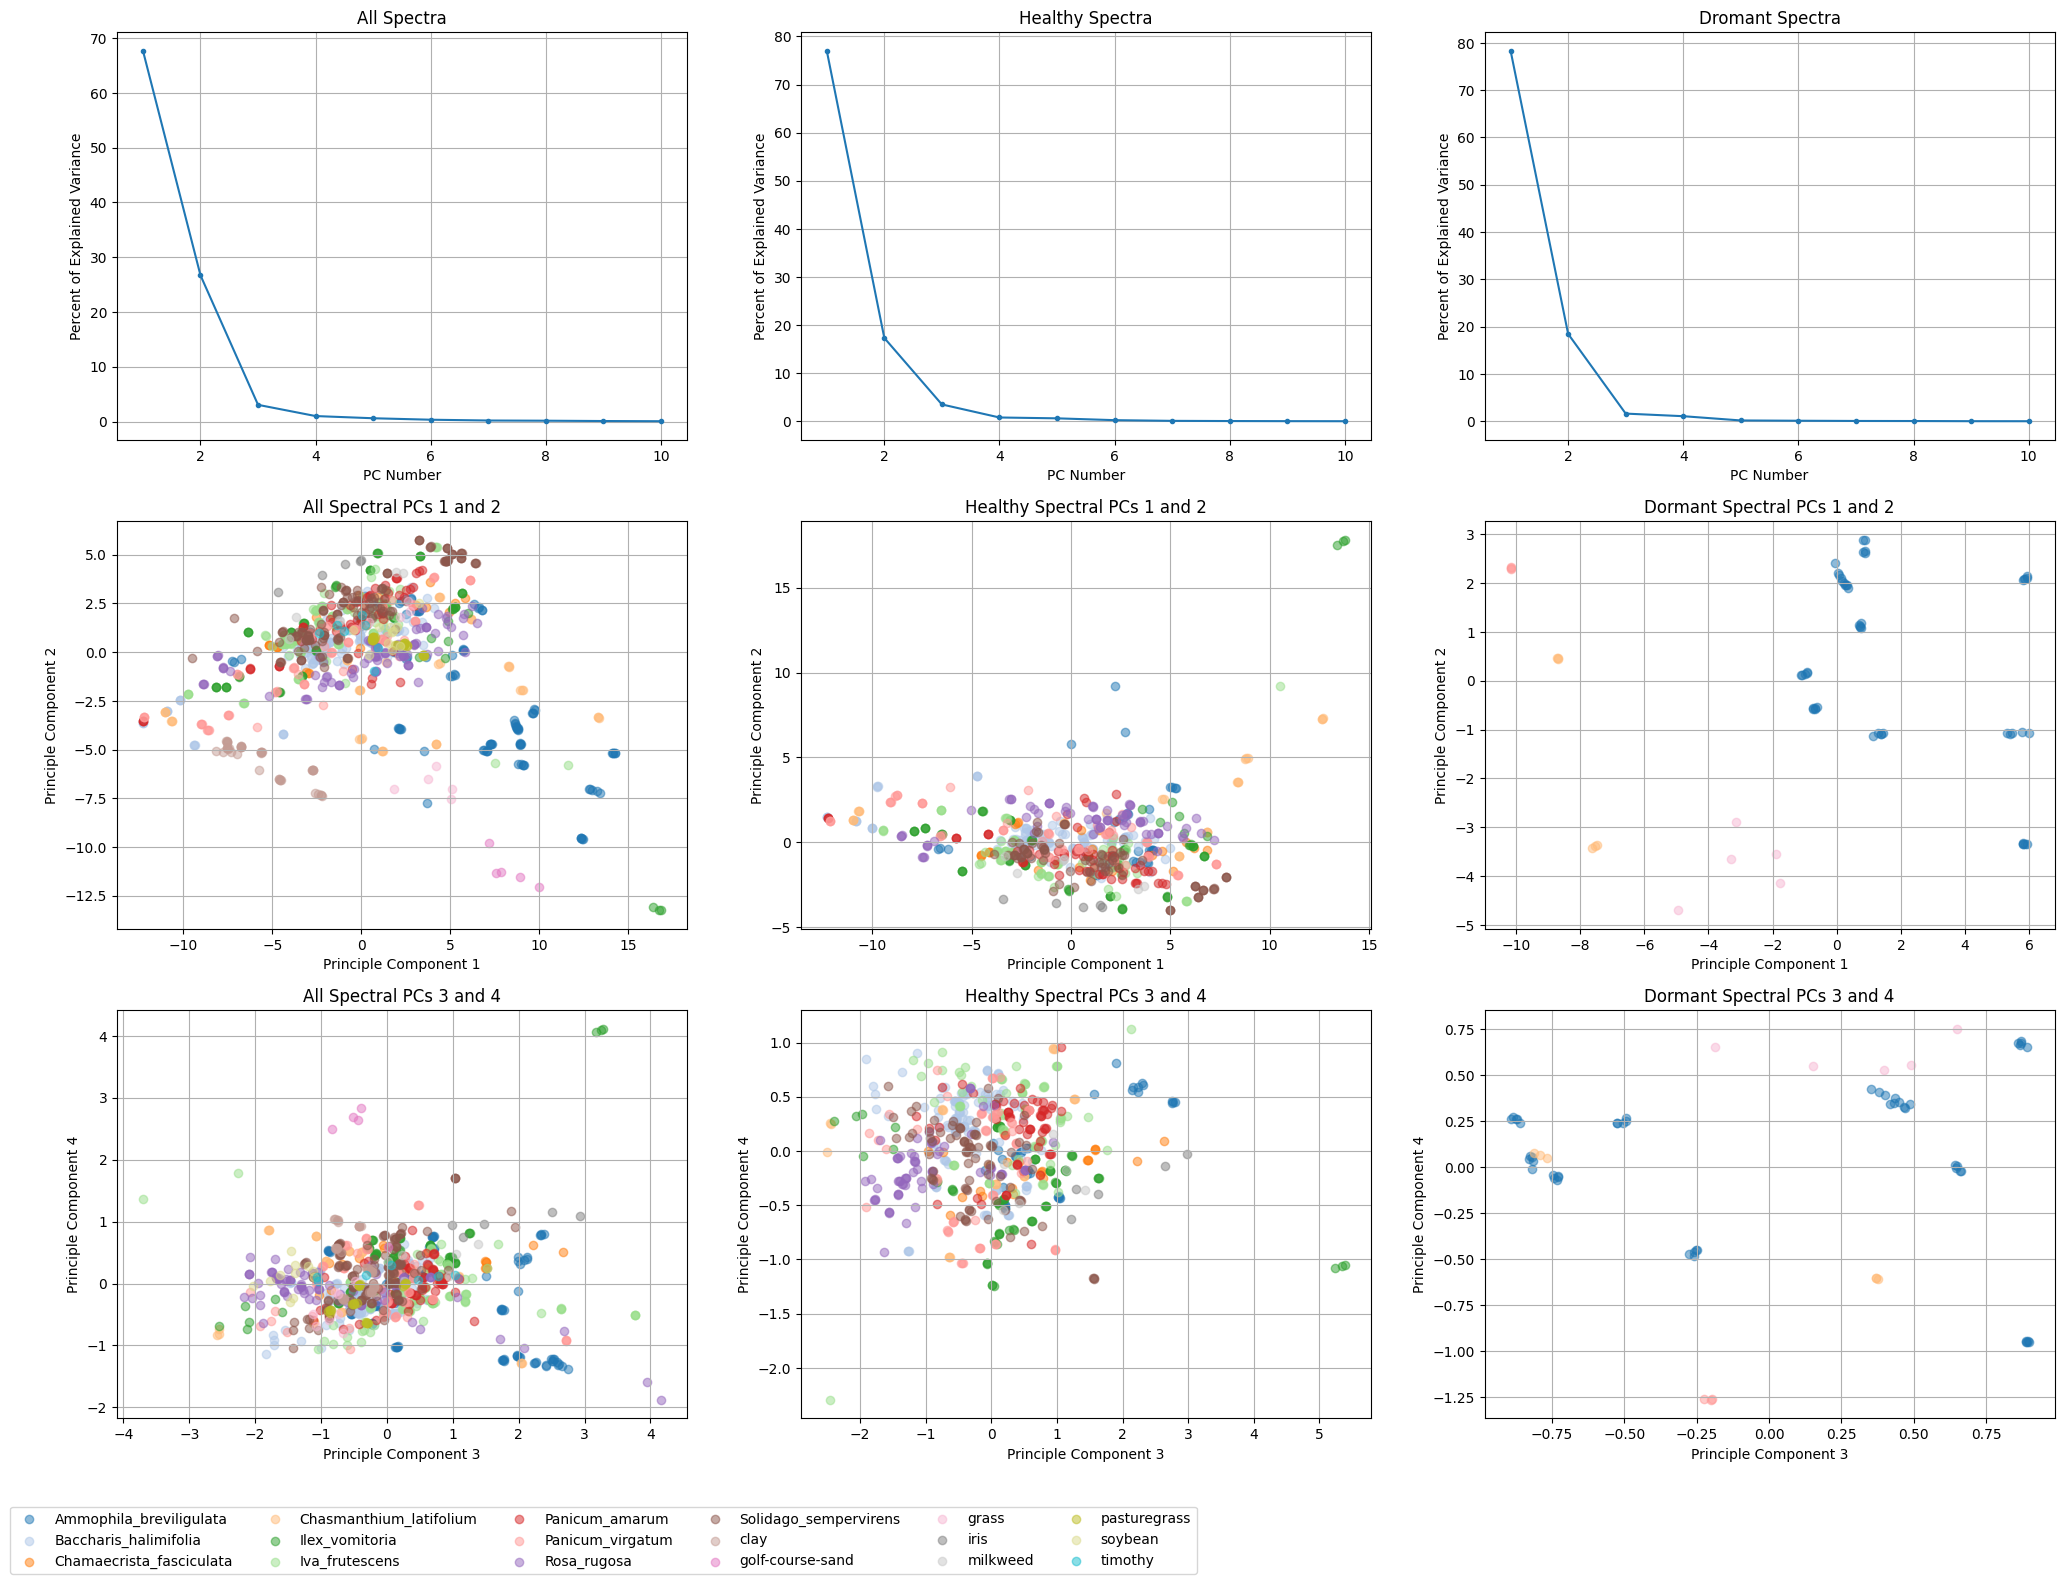

In [12]:
# Analysis of the data in the full, healthy, and dormant subsets, colored by species
fig = plt.figure(figsize=(25,18))

# Variance Analysis
i=1
fig.add_subplot(3,3,i)
plt.plot(np.arange(1,pca_all.n_components_+1), 100*pca_all.explained_variance_ratio_, '.-');
plt.title('All Spectra')
plt.xlabel('PC Number')
plt.ylabel('Percent of Explained Variance')
plt.grid(True)
i=i+1
fig.add_subplot(3,3,i)
plt.plot(np.arange(1,pca_healthy.n_components_+1), 100*pca_healthy.explained_variance_ratio_, '.-');
plt.title('Healthy Spectra')
plt.xlabel('PC Number')
plt.ylabel('Percent of Explained Variance')
plt.grid(True)
i=i+1
fig.add_subplot(3,3,i)
plt.plot(np.arange(1,pca_dormant.n_components_+1), 100*pca_dormant.explained_variance_ratio_, '.-');
plt.title('Dromant Spectra')
plt.xlabel('PC Number')
plt.ylabel('Percent of Explained Variance')
plt.grid(True)

# Scatterplots - PC1 and PC2
i=i+1
fig.add_subplot(3,3,i)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    plt.scatter(pca_all_X[idx,0],pca_all_X[idx,1], alpha=0.5, label=n, c=clr_n[n])
plt.grid(True)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('All Spectral PCs 1 and 2')

i=i+1
fig.add_subplot(3,3,i)
for n in np.unique(name):
    idx = np.where(name[idx_healthy]==n)[0]
    plt.scatter(pca_healthy_X[idx,0],pca_healthy_X[idx,1], alpha=0.5, label=n, c=clr_n[n])
plt.grid(True)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Healthy Spectral PCs 1 and 2')

i=i+1
fig.add_subplot(3,3,i)
for n in np.unique(name):
    idx = np.where(name[idx_dormant]==n)[0]
    plt.scatter(pca_dormant_X[idx,0],pca_dormant_X[idx,1], alpha=0.5, label=n, c=clr_n[n])
plt.grid(True)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Dormant Spectral PCs 1 and 2')

# Scatterplots PC3 and PC3
i=i+1
fig.add_subplot(3,3,i)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    plt.scatter(pca_all_X[idx,2],pca_all_X[idx,3], alpha=0.5, label=n, c=clr_n[n])
plt.grid(True)
plt.xlabel('Principle Component 3')
plt.ylabel('Principle Component 4')
plt.title('All Spectral PCs 3 and 4')
plt.legend(loc='upper left', ncol=6, bbox_to_anchor=(-0.2,-0.2))

i=i+1
fig.add_subplot(3,3,i)
for n in np.unique(name):
    idx = np.where(name[idx_healthy]==n)[0]
    plt.scatter(pca_healthy_X[idx,2],pca_healthy_X[idx,3], alpha=0.5, label=n, c=clr_n[n])
plt.grid(True)
plt.xlabel('Principle Component 3')
plt.ylabel('Principle Component 4')
plt.title('Healthy Spectral PCs 3 and 4')

i=i+1
fig.add_subplot(3,3,i)
for n in np.unique(name):
    idx = np.where(name[idx_dormant]==n)[0]
    plt.scatter(pca_dormant_X[idx,2],pca_dormant_X[idx,3], alpha=0.5, label=n, c=clr_n[n])
plt.grid(True)
plt.xlabel('Principle Component 3')
plt.ylabel('Principle Component 4')
plt.title('Dormant Spectral PCs 3 and 4');

IndexError: index 114 is out of bounds for axis 0 with size 114

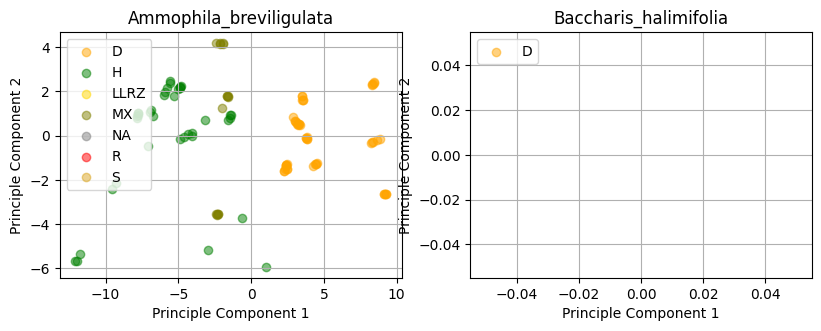

In [13]:
# Plot the PCA scatterplot for each individual species, colored by health
fig = plt.figure(figsize=(15,30))
i=0
for n in np.unique(name):
    fig.add_subplot(8,3,i+1)
    i=i+1
    idx_name = [i for i, x in enumerate(name) if x == n]
    for h in np.unique(health):
        idx_health = [i for i, x in enumerate(health) if x == h]
        idx = list(set(idx_name) & set(idx_health))
        plt.scatter(pca_X[n][idx,0],pca_X[n][idx,1], alpha=0.5, label=h, c=clr_h[h])
        plt.grid(True)
        plt.title(n)
        plt.xlabel('Principle Component 1')
        plt.ylabel('Principle Component 2')
        plt.legend(loc='upper left')
plt.tight_layout()

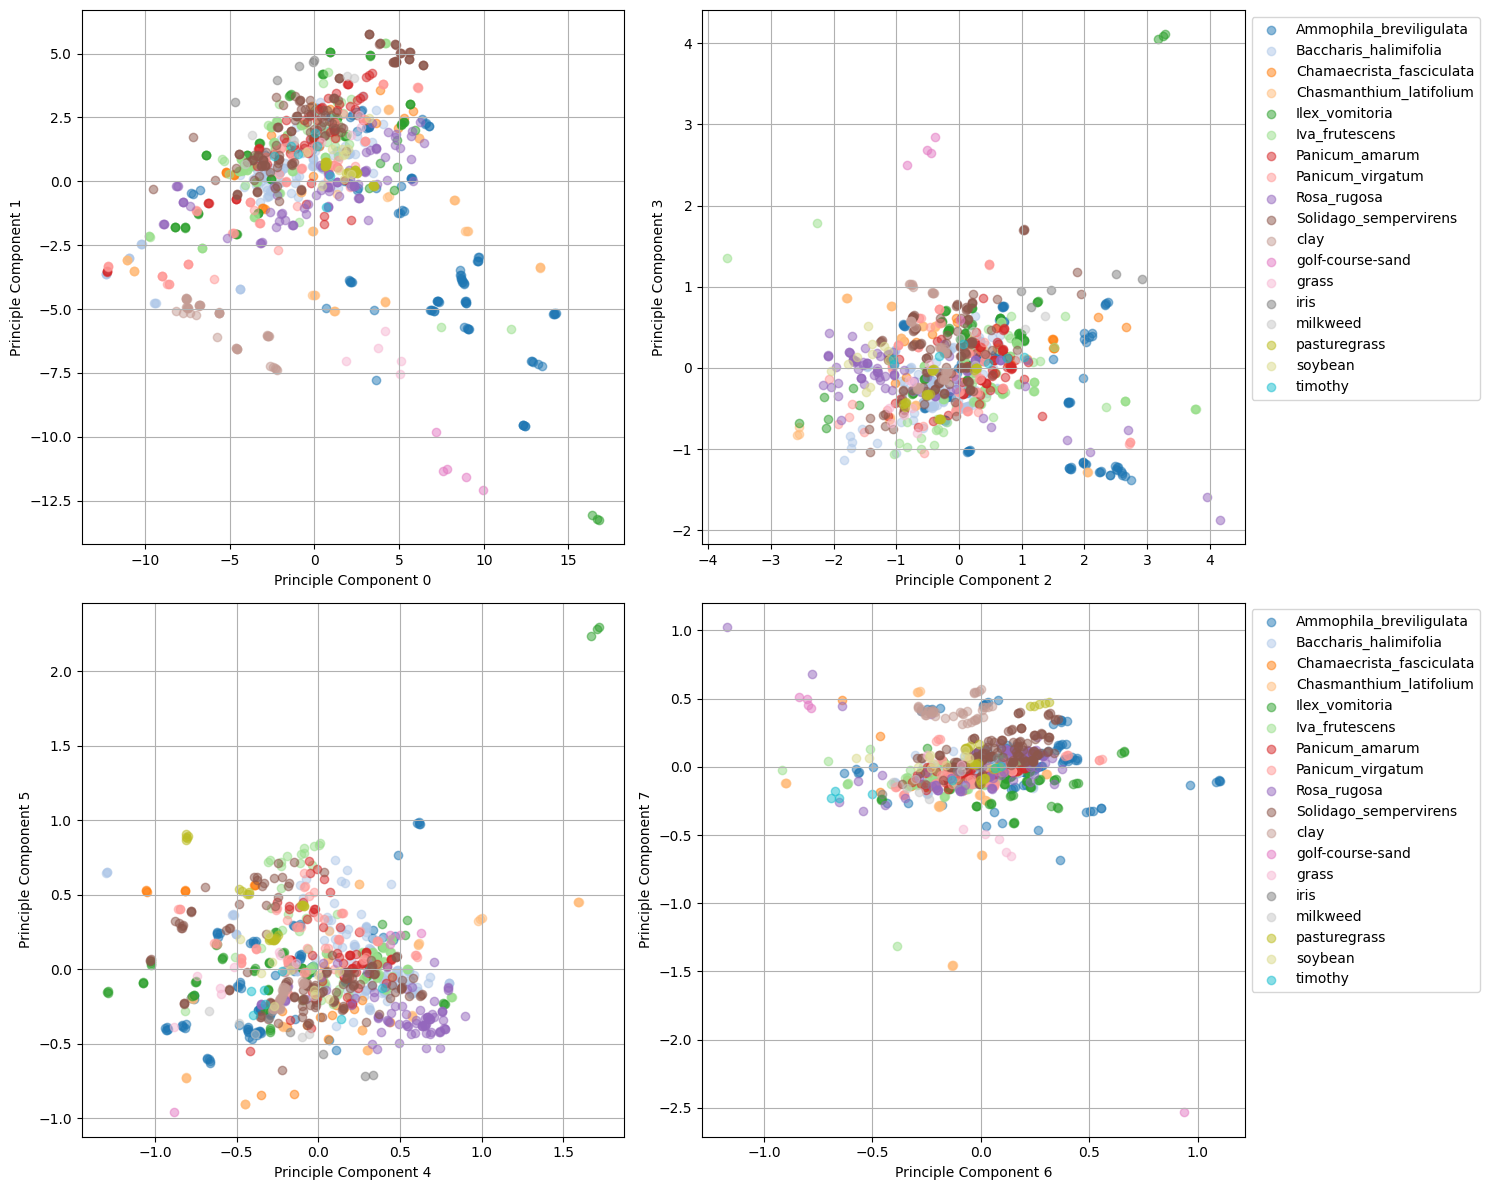

In [ ]:
fig = plt.figure(figsize=(15,12))
fig.add_subplot(221)
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    plt.scatter(pca_all_X[idx_name,0],pca_all_X[idx_name,1], alpha=0.5, label=n, c=clr_n[n])
    plt.grid(True)
    plt.xlabel('Principle Component 0')
    plt.ylabel('Principle Component 1')
fig.add_subplot(222)
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    plt.scatter(pca_all_X[idx_name,2],pca_all_X[idx_name,3], alpha=0.5, label=n, c=clr_n[n])
    plt.grid(True)
    plt.xlabel('Principle Component 2')
    plt.ylabel('Principle Component 3')
    plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1,1))
fig.add_subplot(223)
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    plt.scatter(pca_all_X[idx_name,4],pca_all_X[idx_name,5], alpha=0.5, label=n, c=clr_n[n])
    plt.grid(True)
    plt.xlabel('Principle Component 4')
    plt.ylabel('Principle Component 5')
fig.add_subplot(224)
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    plt.scatter(pca_all_X[idx_name,6],pca_all_X[idx_name,7], alpha=0.5, label=n, c=clr_n[n])
    plt.grid(True)
    plt.xlabel('Principle Component 6')
    plt.ylabel('Principle Component 7')
    plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1,1))
plt.tight_layout()

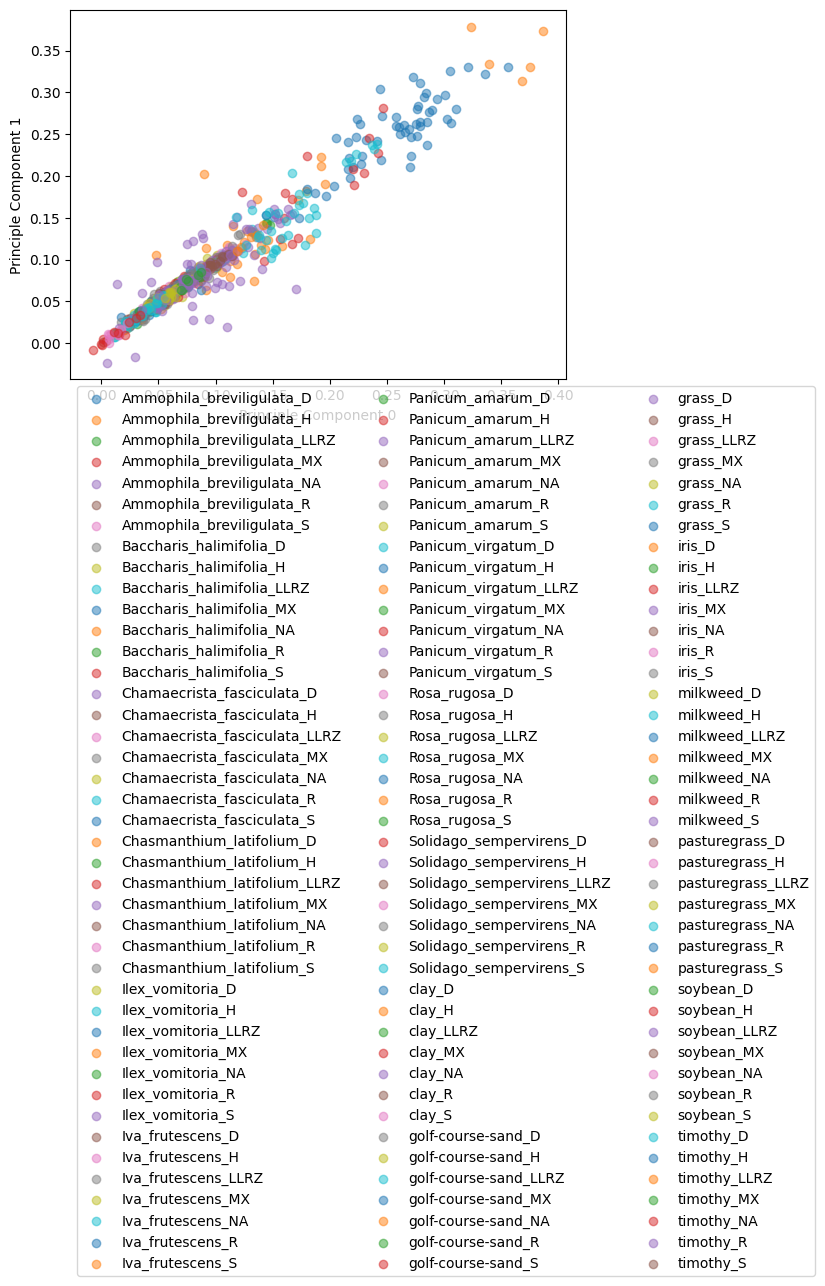

In [ ]:
fig = plt.figure()
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    for h in np.unique(health):
        idx_health = [i for i, x in enumerate(health) if x == h]
        idx = list(set(idx_name) & set(idx_health))
        plt.scatter(X[idx,0],X[idx,1], alpha=0.5, label=n+'_'+h)
        plt.xlabel('Principle Component 0')
        plt.ylabel('Principle Component 1')
        plt.legend(loc='upper left', numpoints=1, ncol=3, bbox_to_anchor=(0, 0))
plt.show()

# Exploration with LDA

In [ ]:
LDA = sklearn.discriminant_analysis.LinearDiscriminantAnalysis

In [ ]:
def lda(data, conf_matrix=False, optimize=False):
    X = data.spec
    y = data.Crop
    run_lda = True

    if run_lda:
        print('LDA classification cross validation.')
        model = LinearDiscriminantAnalysis()
        # define model evaluation method
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # evaluate model
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        # summarize result
        print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

    if conf_matrix:
        print('Computing confusion matrix for LDA.')
        model.fit(X, y)
        cm = confusion_matrix(y, model.predict(X))
        cm_pct = cm.astype(float)
        for i in range(len(np.unique(y))):
            cm_pct[i,:] = cm_pct[i,:]/np.sum(cm_pct[i,:])
        df_cm = pd.DataFrame(cm, np.unique(y), np.unique(y))
        df_cm_pct = pd.DataFrame(cm_pct, np.unique(y), np.unique(y))
        print(np.unique(y))
        print(df_cm)
        print(df_cm_pct)
        sn.set(font_scale=1)  # for label size
        #sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
        sn.heatmap(df_cm_pct, annot=True, annot_kws={"size": 16})  # font size

    if optimize:
        print('Optimizing covariance solver in LDA.')
        model = LinearDiscriminantAnalysis()
        # define model evaluation method
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        # grid search parameter optimization
        # define grid
        grid = dict()
        grid['solver'] = ['svd', 'lsqr', 'eigen']
        # define search
        search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
        # perform the search
        results = search.fit(X, y)
        # summarize
        print('Mean Accuracy: %.3f' % results.best_score_)
        print('Config: %s' % results.best_params_)

    plt.show()
    return np.mean(scores), np.std(scores)

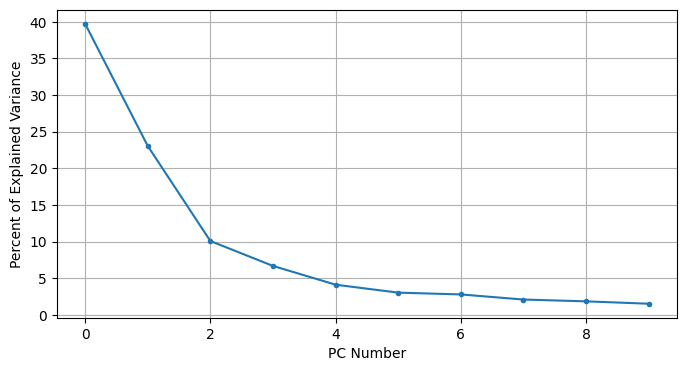

In [ ]:
lda = LDA(n_components=10)
lda.fit(spectra, Yn)
X = lda.transform(spectra)
plt.figure(figsize=(8,4))
plt.plot(100*lda.explained_variance_ratio_, '.-');
plt.xlabel('PC Number')
plt.ylabel('Percent of Explained Variance')
plt.grid(True)

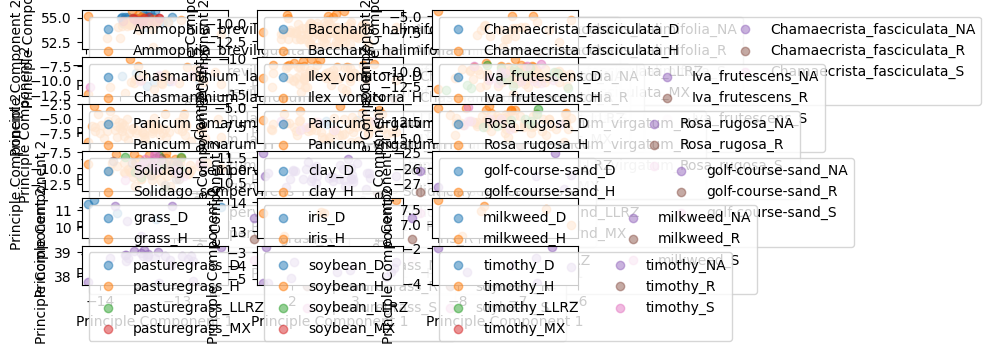

In [ ]:
fig = plt.figure()
i=0
for n in np.unique(name):
    fig.add_subplot(8,3,i+1)
    i=i+1
    idx_name = [i for i, x in enumerate(name) if x == n]
    for h in np.unique(health):
        idx_health = [i for i, x in enumerate(health) if x == h]
        idx = list(set(idx_name) & set(idx_health))
        plt.scatter(X[idx,0],X[idx,1], alpha=0.5, label=n+'_'+h)
        plt.xlabel('Principle Component 1')
        plt.ylabel('Principle Component 2')
        plt.legend(loc='upper left', numpoints=1, ncol=2, bbox_to_anchor=(0, 1))
plt.show()

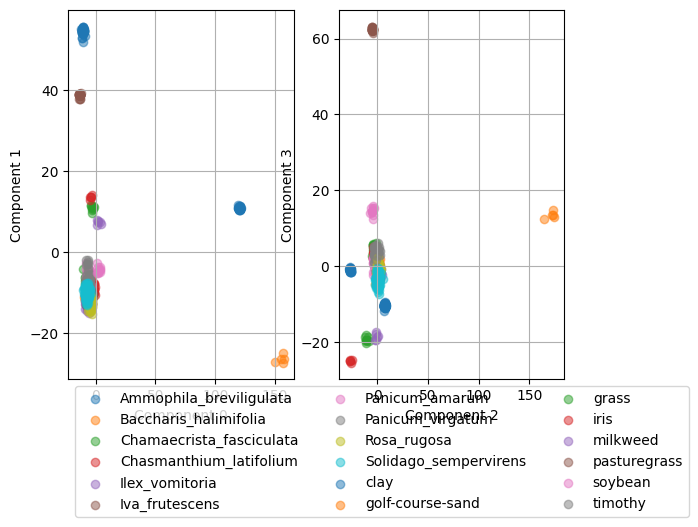

In [ ]:
fig = plt.figure()
fig.add_subplot(121)
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    plt.scatter(X[idx_name,0],X[idx_name,1], alpha=0.5, label=n)
    plt.xlabel('Component 0')
    plt.ylabel('Component 1')
    plt.grid(True)
    plt.legend(loc='upper left', numpoints=1, ncol=3, bbox_to_anchor=(0, 0))
fig.add_subplot(122)
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    plt.scatter(X[idx_name,2],X[idx_name,3], alpha=0.5, label=n)
    plt.xlabel('Component 2')
    plt.ylabel('Component 3')
    plt.grid(True)
plt.show()

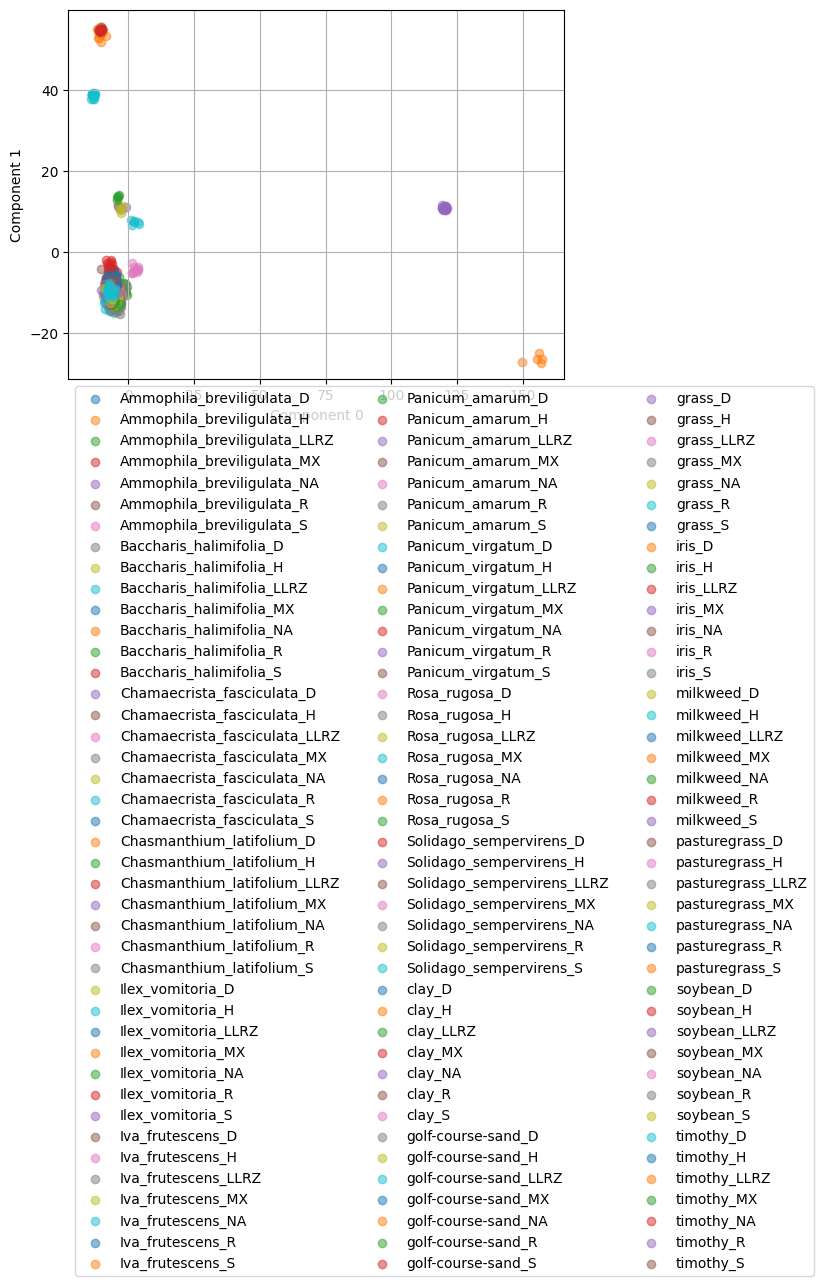

In [ ]:
fig = plt.figure()
for n in np.unique(name):
    idx_name = [i for i, x in enumerate(name) if x == n]
    for h in np.unique(health):
        idx_health = [i for i, x in enumerate(health) if x == h]
        idx = list(set(idx_name) & set(idx_health))
        plt.scatter(X[idx,0],X[idx,1], alpha=0.5, label=n+'_'+h)
        plt.xlabel('Component 0')
        plt.ylabel('Component 1')
        plt.grid(True)
        plt.legend(loc='upper left', numpoints=1, ncol=3, bbox_to_anchor=(0, 0))
plt.show()